<a href="https://colab.research.google.com/github/Mohamedragih1/Image-Carbonification-and-Road-Lane-Detection-/blob/main/Road_Lane_Detection_HT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import math

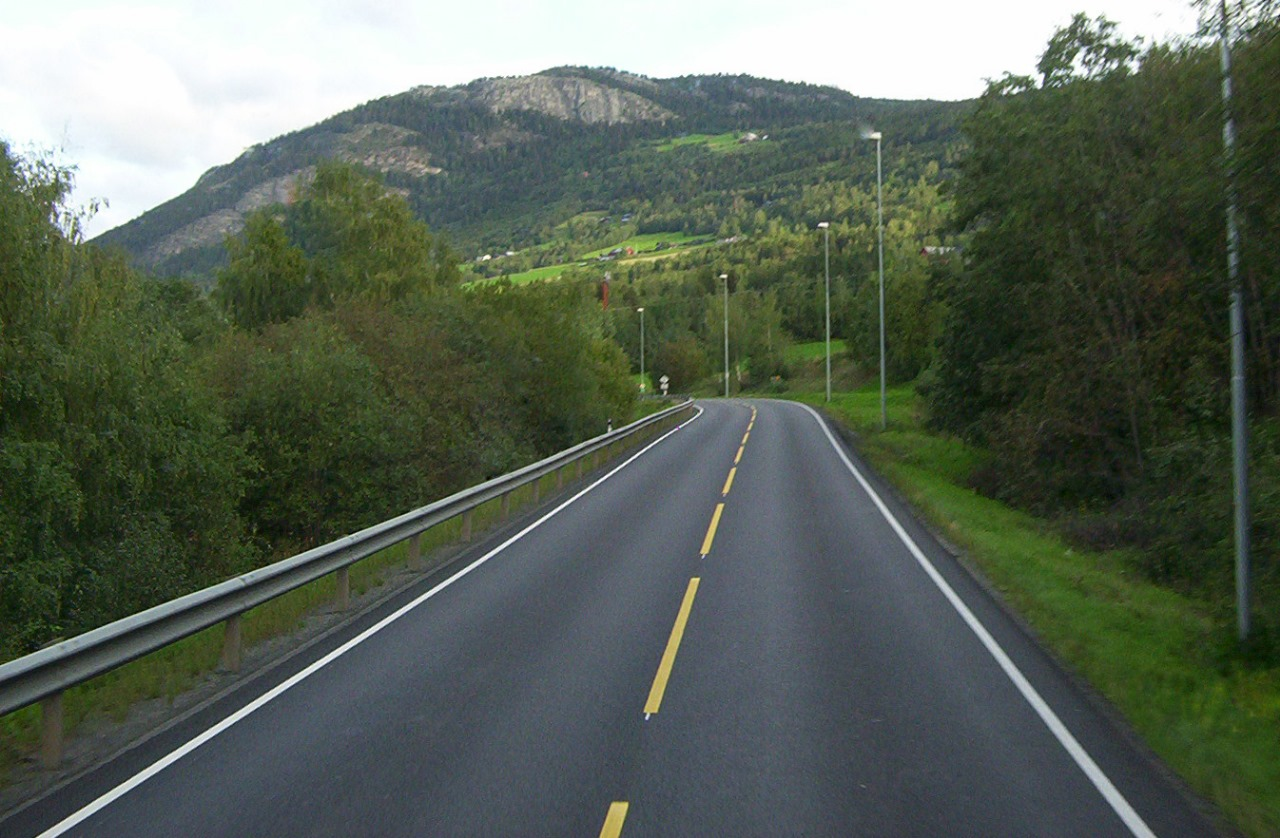

In [ ]:
image = cv2.imread('norway-rode.jpeg')
cv2_imshow(image)

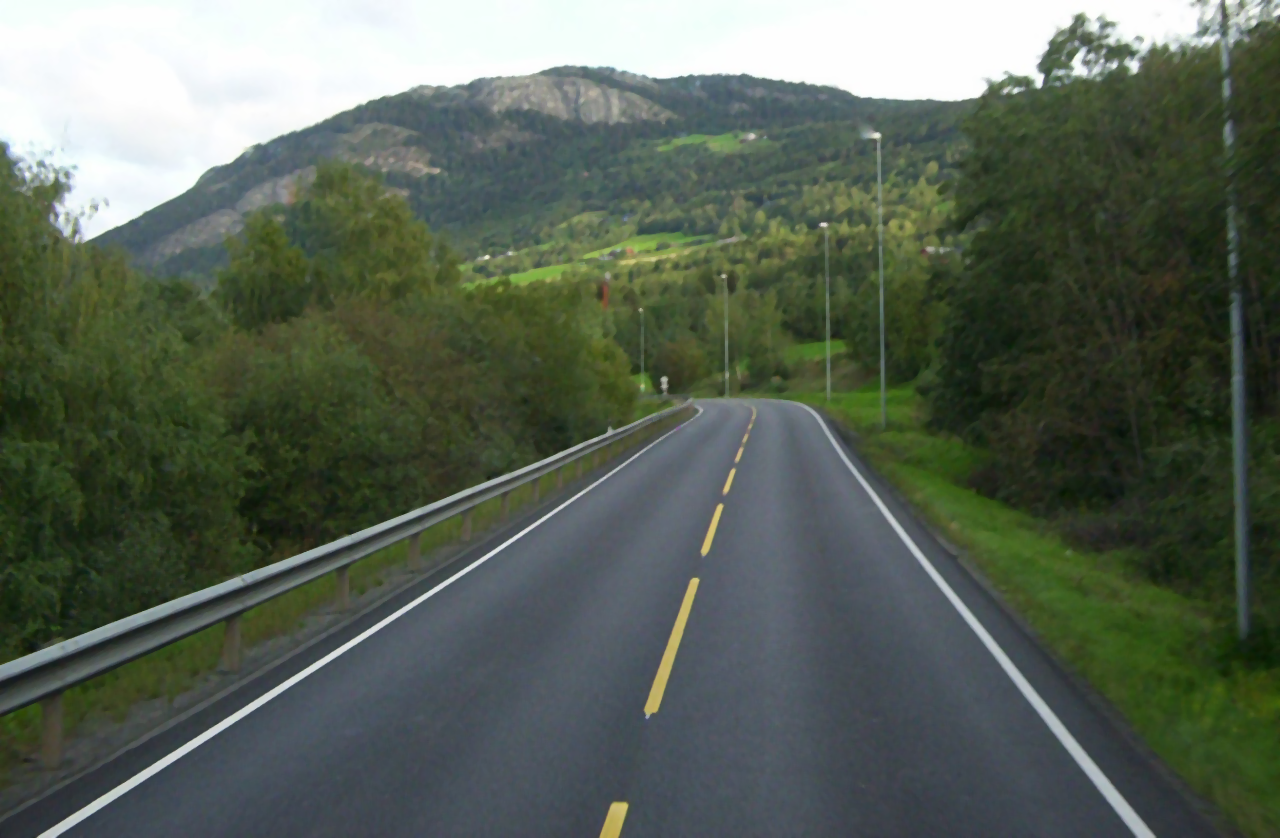

In [ ]:
smoothed_image = cv2.medianBlur(image, 5)
cv2_imshow(smoothed_image)

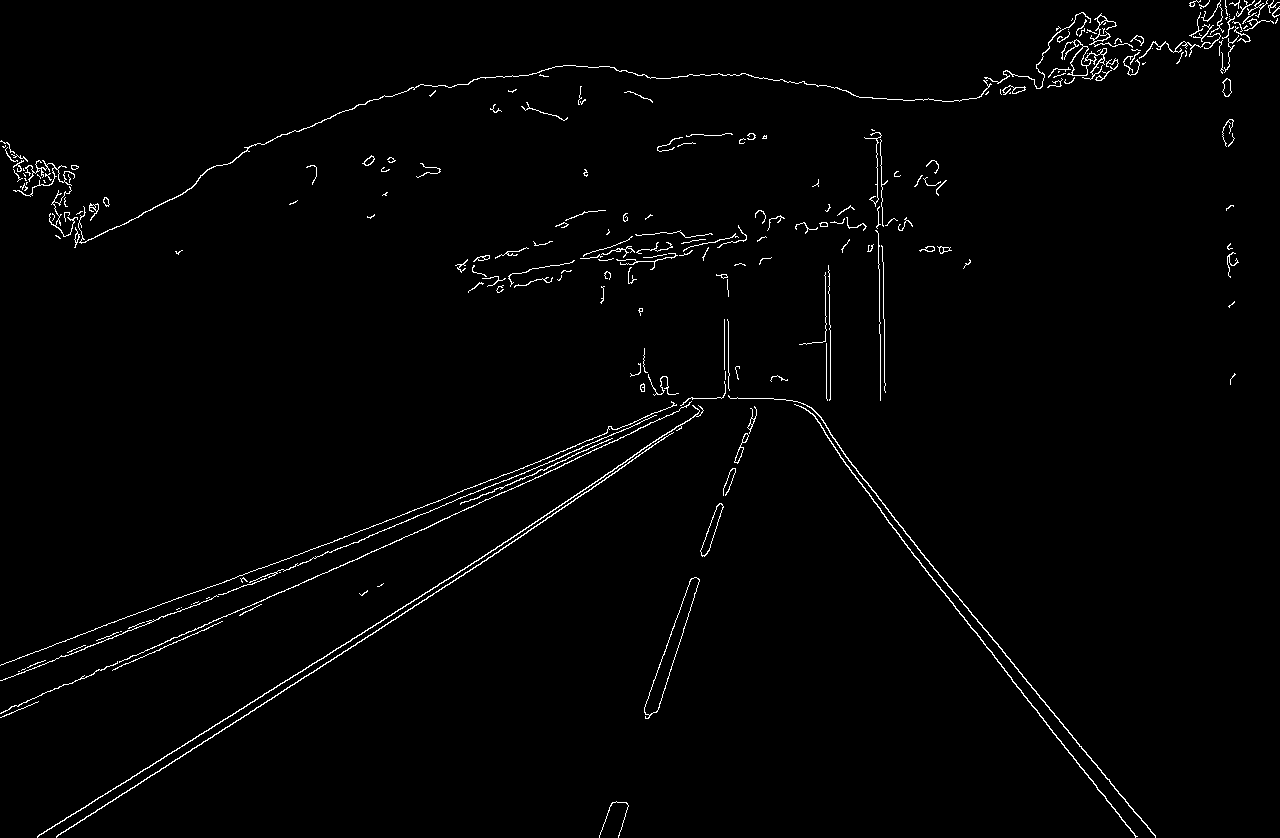

In [ ]:
#grey_image = cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2GRAY)
edges_image = cv2.Canny(smoothed_image, 100, 200)
cv2_imshow(edges_image)

In [ ]:
# Displaying the image with a grid to aid in finding coordinates
image_RGB = cv2.cvtColor(edges_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_RGB)

In [ ]:
#defining the poly points
#polygon_points = np.array([[0,860],[700,405],[900,420],[1346,882]])
polygon_points = np.array([[(0, 700), (0, 450), (420, 320), (800, 320), (1000, 700)]])
# Create a copy of the image to draw the polygon on
image_with_polygon = edges_image.copy()

# Draw the polygon on the image
cv2.polylines(image_with_polygon, [polygon_points], isClosed=True, color=(255, 0, 0), thickness=2)
cv2_imshow(image_with_polygon)

In [ ]:
#Creating a blank mask with the same dimensions as the image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Fill the polygon on the mask with white (255)
cv2.fillPoly(mask, [polygon_points], 255)

# Apply the mask to the image using bitwise_and to keep only the ROI
masked_image = cv2.bitwise_and(edges_image, edges_image, mask=mask)
cv2_imshow(masked_image)

In [ ]:
import numpy as np
import math

def Hough_transform(image, theta_bins=180):
    height, width = image.shape[:2]
    row_bins = math.ceil(np.linalg.norm((height, width)))
    Accumulator_array = np.zeros((2 * row_bins, theta_bins + 1))


    for y, x in zip(*np.where(image == 255)):
                for angle in range(0,theta_bins+1):
                    rho = round(x * math.cos(np.deg2rad(angle)) + y * math.sin(np.deg2rad(angle)))
                    Accumulator_array[row_bins - rho, angle] = Accumulator_array[row_bins - rho, angle] + 1
    flat_arr = Accumulator_array.flatten()
    top_10_values = np.partition(flat_arr, -10)[-10:]
    top_10_values = np.sort(top_10_values)[::-1]
    print(top_10_values)

    return Accumulator_array, row_bins, theta_bins

In [ ]:
accumulator, max_rho, max_theta = Hough_transform(masked_image)

In [ ]:
def non_max_suppression(prediction, kernel_size):
    height, width = prediction.shape[:2]
    result = np.zeros_like(prediction)

    prediction = np.pad(prediction, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2)), mode='constant', constant_values=0)

    for x in range(kernel_size // 2, height + kernel_size // 2):
        for y in range(kernel_size // 2, width + kernel_size // 2):
            if prediction[x, y] >= np.max(prediction[x - kernel_size // 2: x + kernel_size // 2 + 1, y - kernel_size // 2: y + kernel_size // 2 + 1]) \
                and prediction[x, y] > 0:
                result[x - kernel_size // 2, y - kernel_size // 2] = 255
            else:
                result[x - kernel_size // 2, y - kernel_size // 2] = 0

    return result

In [ ]:
threshold = 220
thresh_acc = accumulator.copy()
thresh_acc[thresh_acc < threshold] = 0
thresh_acc = non_max_suppression(thresh_acc, 7)
lines = np.argwhere(thresh_acc == 255).astype(np.float64)
lines[:, 0] = max_rho - lines[:, 0]
lines[:, 1] = np.deg2rad(lines[:, 1])

In [ ]:
accumulator[accumulator > 0] += 25

plt.imshow(accumulator, cmap='gray', extent=[0, 180, -max_rho, max_rho],  aspect='auto')

plt.xlabel('Theta (degrees)')
plt.ylabel('Rho')
plt.title('Hough Space')

plt.show()

In [ ]:
def draw_line(image, lines, roi_vertices, thickness=2):
    image_with_lines = np.zeros_like(image)

    # Creating a mask to apply to the drawn lines
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [roi_vertices], 255)

    extension_length = max(image_with_lines.shape[0], image_with_lines.shape[1])

    for (rho, theta) in lines:
      a = np.cos(theta)
      b = np.sin(theta)

      x0 = a * rho
      y0 = b * rho

      x1 = int(x0 + extension_length * b)
      y1 = int(y0 + extension_length * -a)
      x2 = int(x0 - extension_length * b)
      y2 = int(y0 - extension_length * -a)

      cv2.line(image_with_lines, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=thickness)

    # Applying the mask
    masked_lines = cv2.bitwise_and(image_with_lines[:, :, 1], mask[:, :, 0])

    # Adding masked lines to the original image's green channel
    image_with_masked_lines = image.copy()
    image_green_channel = image_with_masked_lines[:, :, 1]
    image_green_channel[masked_lines > 0] = 255
    image_with_masked_lines[:, :, 1] = image_green_channel

    cv2_imshow(image_with_masked_lines)

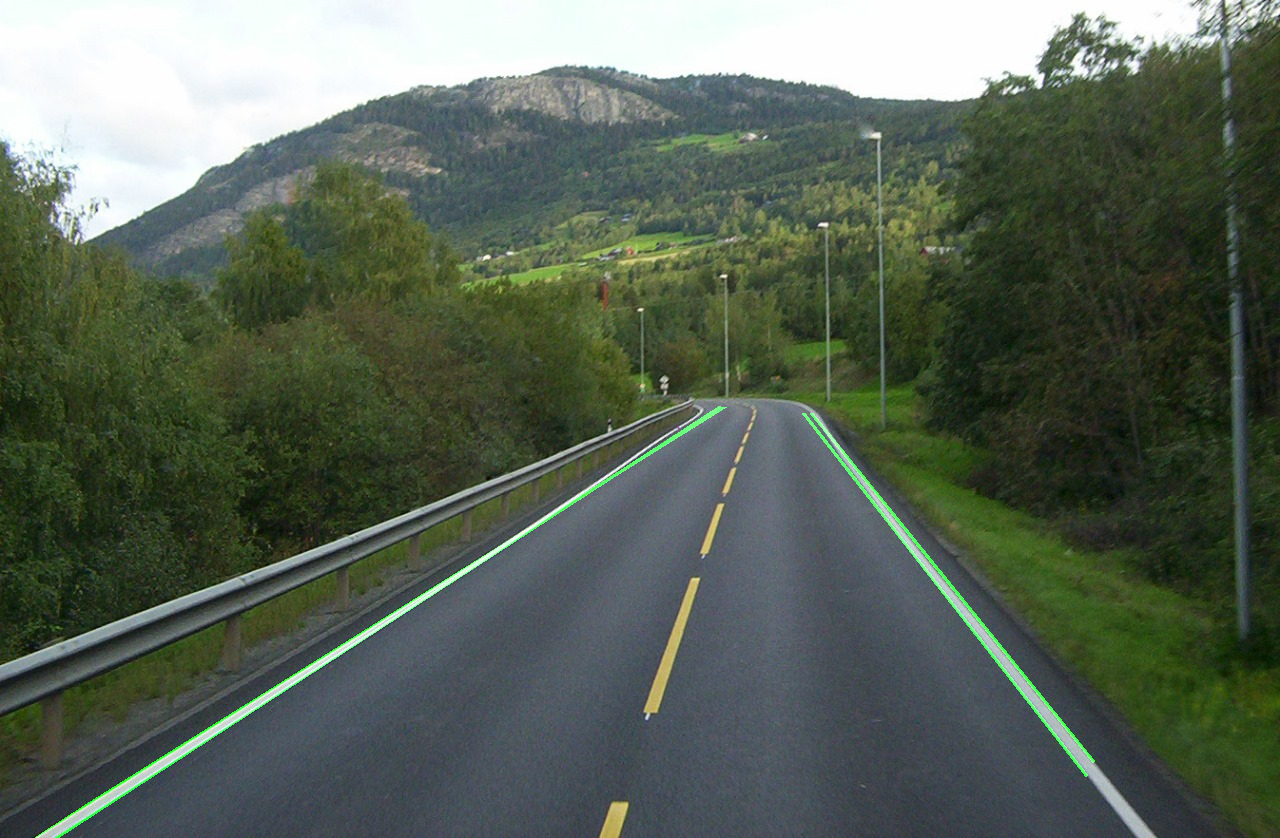

In [ ]:
draw_line(image, lines, polygon_points)